In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

# CoNLL 2002 data

In [6]:
# import nltk
# nltk.download('conll2002')

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\jhu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\conll2002.zip.


True

In [7]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [8]:
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

In [9]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

In [10]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [11]:
sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'melbourne',
 'word[-3:]': 'rne',
 'word[-2:]': 'ne',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'BOS': True,
 '+1:word.lower()': '(',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp'}

In [12]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [13]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

C:\Users\jhu\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [14]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [15]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7964686316443963

In [16]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

C:\Users\jhu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-LOC      0.810     0.784     0.797      1084
       I-LOC      0.690     0.637     0.662       325
      B-MISC      0.731     0.569     0.640       339
      I-MISC      0.699     0.589     0.639       557
       B-ORG      0.807     0.832     0.820      1400
       I-ORG      0.852     0.786     0.818      1104
       B-PER      0.850     0.884     0.867       735
       I-PER      0.893     0.943     0.917       634

   micro avg      0.813     0.787     0.799      6178
   macro avg      0.791     0.753     0.770      6178
weighted avg      0.809     0.787     0.796      6178



In [17]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 22.6min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A404F2B460>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A4094F7AC0>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']),
                   verbose=1)

In [18]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.16009461826928975, 'c2': 0.02755141021011392}
best CV score: 0.7494872620162331
model size: 1.23M


Dark blue => 0.7041, dark red => 0.7495


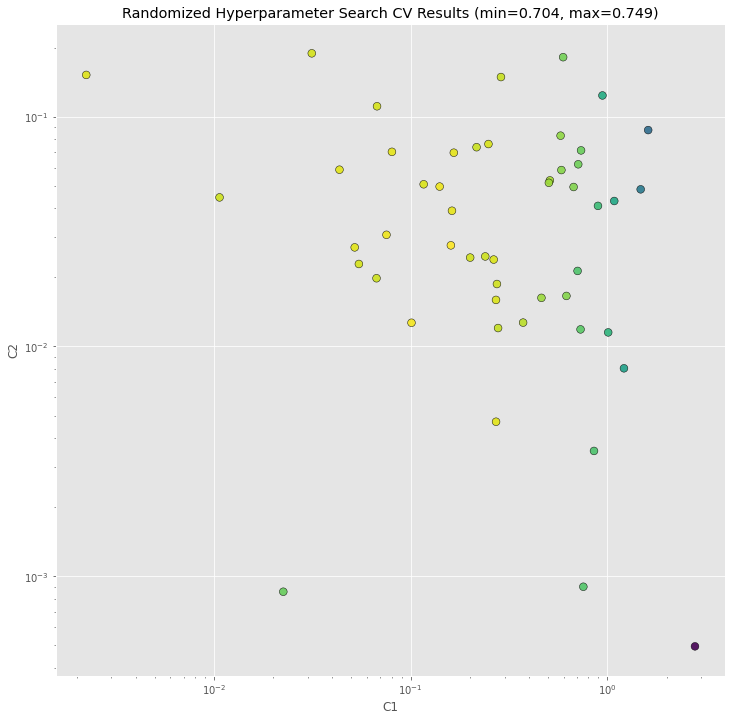

In [30]:
_x = rs.cv_results_["param_c1"]
_y = rs.cv_results_["param_c2"]
_c = rs.cv_results_["mean_test_score"]



fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [31]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.805     0.783     0.794      1084
       I-LOC      0.676     0.637     0.656       325
      B-MISC      0.718     0.555     0.626       339
      I-MISC      0.701     0.576     0.633       557
       B-ORG      0.810     0.835     0.822      1400
       I-ORG      0.847     0.782     0.813      1104
       B-PER      0.848     0.880     0.864       735
       I-PER      0.889     0.943     0.915       634

   micro avg      0.810     0.784     0.797      6178
   macro avg      0.787     0.749     0.765      6178
weighted avg      0.806     0.784     0.793      6178



In [33]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.242260
I-ORG  -> I-ORG   6.974288
I-MISC -> I-MISC  6.703445
B-MISC -> I-MISC  6.519786
B-PER  -> I-PER   6.117211
B-LOC  -> I-LOC   5.465919
I-PER  -> I-PER   4.824878
I-LOC  -> I-LOC   4.735472
O      -> O       4.083009
O      -> B-ORG   2.773211
O      -> B-PER   2.363283
O      -> B-LOC   1.759445
O      -> B-MISC  1.725927
I-PER  -> B-LOC   0.385576
B-ORG  -> O       0.379724
B-MISC -> B-ORG   0.062941
B-LOC  -> B-LOC   0.054097
B-ORG  -> B-LOC   -0.003858
B-LOC  -> O       -0.188728
B-MISC -> O       -0.264129

Top unlikely transitions:
I-LOC  -> B-MISC  -2.742681
I-MISC -> I-PER   -2.776139
I-MISC -> I-ORG   -2.795003
I-LOC  -> I-PER   -2.854152
I-MISC -> B-LOC   -2.956192
I-ORG  -> I-PER   -2.984794
B-PER  -> B-MISC  -2.991086
I-PER  -> B-ORG   -3.005849
I-PER  -> I-LOC   -3.024711
I-ORG  -> B-MISC  -3.076100
B-ORG  -> B-MISC  -3.253239
I-ORG  -> I-LOC   -3.384299
I-PER  -> B-MISC  -3.445014
I-MISC -> I-LOC   -3.571663
B-PER  -> B-PE

In [34]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
12.154812 B-ORG    word.lower():efe-cantabria
11.122133 B-ORG    word.lower():psoe-progresistas
8.564275 B-ORG    word.lower():petrobras
7.731951 I-ORG    -1:word.lower():l
7.683483 B-ORG    word.lower():coag-extremadura
7.305051 I-ORG    -1:word.lower():rasd
6.828097 B-LOC    +1:word.lower():finalizaron
6.801799 B-MISC   word.lower():cc2305001730
6.719695 B-ORG    word[-2:]:-e
6.642118 B-ORG    word.lower():xfera
6.514612 B-ORG    -1:word.lower():distancia
6.394158 B-ORG    +1:word.lower():plasencia
6.322675 B-MISC   word.lower():diversia
6.316746 I-ORG    -1:word.lower():ag
6.239439 B-LOC    -1:word.lower():celebrarán
6.224056 B-ORG    word.lower():eu-ecologista
6.177522 B-LOC    -1:word.lower():cantabria
6.069878 B-MISC   word.lower():vaciamadrid
5.993392 B-ORG    -1:word.lower():sociolaboral
5.988022 B-PER    word.lower():orduña
5.959488 O        word.lower():r.
5.959488 O        word[-3:]:R.
5.838687 B-ORG    word.lower():telefónica
5.757265 I-LOC    -1:word.lower():